## Importes

Realizamos los importes necesarios para nuestro modelo

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
import pickle

from ast import literal_eval
#La lista tokens en la columna tokens es en realidad una representación de una lista hecha con un string, literal_eval lo transforma en una lista real

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [67]:
partes_train = []
cant_partes = 2
for i in range(cant_partes):
  parte = pd.read_csv(f'https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/train_data_procesado_FILTRADO_FINAL_parte_{i}.csv')
  partes_train.append(parte)
train_data = pd.concat(partes_train, ignore_index=True)

test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/test_data_procesado_FILTRADO_FINAL.csv"
test_data = pd.read_csv(test_url)

Concatenamos los tokens en una unica lista de texto y lo utilizamos para crear y entrenar el vectorizer; tanto para train como para test

In [68]:
#Transformamos train_data['tokens'] y test_data['tokens] en listas reales (antes eran representaciónes de lista hechas en string)
train_data['tokens'] = train_data['tokens'].apply(literal_eval)
test_data['tokens'] = test_data['tokens'].apply(literal_eval)

vectorizer = CountVectorizer()

corpus = [' '.join(tokens) for tokens in train_data['tokens']]
X = vectorizer.fit_transform(corpus)

corpus_test = [' '.join(tokens) for tokens in test_data['tokens']]
X_test_data = vectorizer.transform(corpus_test)

Obtenemos las etiquetas y dividivos los datos en conjunto de train y test

In [69]:
y = train_data['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Dado que Random Forest tarda en correr, vamos a obtener una subclasificación de nuestra división de datos, así mejoramos el tiempo de optimización de hiperparametros

In [70]:
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)

## Funciones

A Continuación, crearemos distintas funciones que serán utilizadas a lo largo del trabajo.

### mostrar_resultados

Esta función, recibe los mejores parametros encontrados, los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra las distintas metricas obtenidas del modelo.

In [71]:
def mostrar_resultados(model, best_params, X_train, y_train, X_test, y_test):
  print("Mejores hiperparámetros encontrados:", best_params)

  # Metricas en el conjunto de entrenamiento
  y_train_pred = model.predict(X_train)

  print("Métricas de evaluación en el conjunto de entrenamiento:")
  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("Recall:", recall_score(y_train, y_train_pred, average='macro'))
  print("F1-Score:", f1_score(y_train, y_train_pred, average='macro'))
  print("Precision:", precision_score(y_train, y_train_pred, average='macro'))

  # Metricas en el conjunto de prueba
  y_test_pred = model.predict(X_test)

  print("\nMétricas de evaluación en el conjunto de prueba:")
  print("Accuracy:", accuracy_score(y_test, y_test_pred))
  print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
  print("F1-Score:", f1_score(y_test, y_test_pred, average='macro'))
  print("Precision:", precision_score(y_test, y_test_pred, average='macro'))

### mostrar_matriz_confusion

La siguiuente función recibe un modelo, y los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra la matriz de confusión correspondiente para cada caso

In [72]:
def mostrar_matriz_confusion(model, X_train, y_train, X_test, y_test):
  y_train_pred = model.predict(X_train)
  cm_train = confusion_matrix(y_train, y_train_pred)

  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de entrenamiento')
  plt.show()

  print("\n\n")

  y_test_pred = model.predict(X_test)
  cm_train = confusion_matrix(y_test, y_test_pred)
  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de prueba')

  plt.show()

## Random Forest

Creamos el modelo de Random Forest y definimos los hiperparámetros a usar

In [73]:
random_forest = RandomForestClassifier()

hyperparameters = {
    'n_estimators': [100, 120, 140],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

Realizamos la optimización de los hiperparametros utliizando Random Search con Cross Validation de 5. Usamos una porción de nuestros datos, ya que este modelo tarda mucho

In [74]:
random_search_rf = RandomizedSearchCV(random_forest, hyperparameters, cv=5, n_iter=100, random_state=42, n_jobs=-1, verbose = 10)
random_search_rf.fit(X_train_sub, y_train_sub)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 30, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 120, 140],
                                        'random_state': [42]},
                   random_state=42, verbose=10)

Obteneoms los mejores parametros y entrenamos el modelo a partir de ellos

In [75]:
best_params_rf = random_search_rf.best_params_

best_random_forest = RandomForestClassifier(**best_params_rf)
best_random_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=140, random_state=42)

Veamos los resultados obtenidos para test y train

In [76]:
mostrar_resultados(best_random_forest, best_params_rf, X_train, y_train, X_test, y_test)

Mejores hiperparámetros encontrados: {'random_state': 42, 'n_estimators': 140, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}
Métricas de evaluación en el conjunto de entrenamiento:
Accuracy: 0.884969037342841
Recall: 0.8849814520000501
F1-Score: 0.8849689360768296
Precision: 0.8849875074070015

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.827276707530648
Recall: 0.8272955284742203
F1-Score: 0.8272687524954276
Precision: 0.8273752914468033


Y mostramos las respectivas matrices de confusión

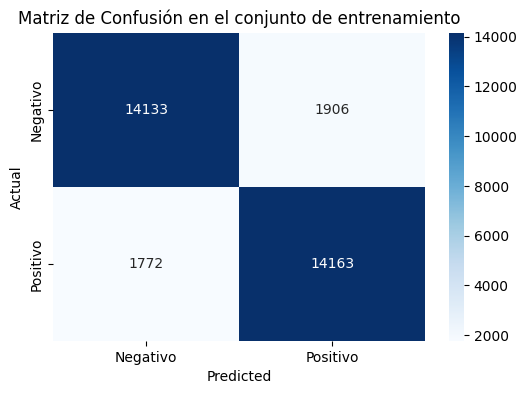

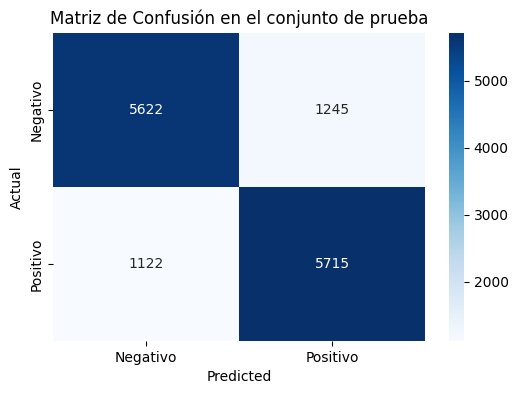

In [77]:
mostrar_matriz_confusion(best_random_forest, X_train, y_train, X_test, y_test)

Guardamos el modelo en un archivo .pkl y luego lo cargamos para hacer uso del mismo

In [81]:
with open('modelo_random_forest.pkl', 'wb') as file:
    pickle.dump(best_random_forest, file)

with open('modelo_random_forest.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Realizamos las predicciones en el conjunto test_data, realizando el mapeo correspondiente para que vuelva a ser sentimiento positivo y negativo

In [82]:
y_test_data_pred = loaded_model.predict(X_test_data)
y_test_data_pred = np.where(y_test_data_pred == 0, 'negativo', 'positivo')

Obtenemos un dataframe con las predicciones con la estructura pedida en la consigna y lo descargamos para subirlo a la competencia de Kaggle

In [83]:
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'sentimiento': y_test_data_pred})
predictions_df.to_csv('predicciones_rf_final.csv', index=False)